# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time


# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
 
}




common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
    

# 'delta for galaxies' : "200c",
# 'delta for matter density' : "200c",
# 'delta for electron density':"200c",    

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',

'hm_consistency' : 1,
'x_outSZ': 4.,
'truncate_wrt_rvir':0,
}

Metal device set to: Apple M1 Pro


2023-05-22 14:10:45.676794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-22 14:10:45.676930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import classy_sz
classy_sz.__file__


'/Users/boris/opt/miniconda3/lib/python3.9/site-packages/classy_sz-2.9.4-py3.9-macosx-11.0-arm64.egg/classy_sz.cpython-39-darwin.so'

# compute class_szfast

In [54]:
%%time

M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'tSZ_1h,tSZ_2h',

'pressure profile':'Custom. GNFW',
    
"P0GNFW": 8.130,
"c500": 1.156,
"gammaGNFW": 0.3292,
"alphaGNFW": 1.0620,
"betaGNFW":5.4807,

"ell_min" : 2,
"ell_max" : 8000,
'dell': 0,
'dlogell': 0.2,
    
'M_min' : 1.0e10, 
'M_max' : 5e14,
    
'z_min' : 0.5,
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster


    
    
'hm_consistency' : 1,
    

'use_fft_for_profiles_transform' : 1,

'N_samp_fftw' : 512,
'x_min_gas_pressure_fftw' : 1e-4,
'x_max_gas_pressure_fftw' : 1e3,
    
    
# 'ndim_masses' : 500, # now muted/set by k's in cosmopower emulator.
'ndim_redshifts' :50,

    
'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0001,    

    
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0001,
    
# # testing with 3 massive neutrinos
# 'N_ncdm': 3,
# 'N_ur': 0.00641,
# 'm_ncdm': '0.06,0.06,0.06', 
})
M.compute_class_szfast()
# M.compute()

CPU times: user 375 ms, sys: 68.8 ms, total: 444 ms
Wall time: 229 ms


In [55]:
l = np.asarray(M.cl_sz()['ell'])
cl_yy_1h = np.asarray(M.cl_sz()['1h'])
cl_yy_2h = np.asarray(M.cl_sz()['2h'])

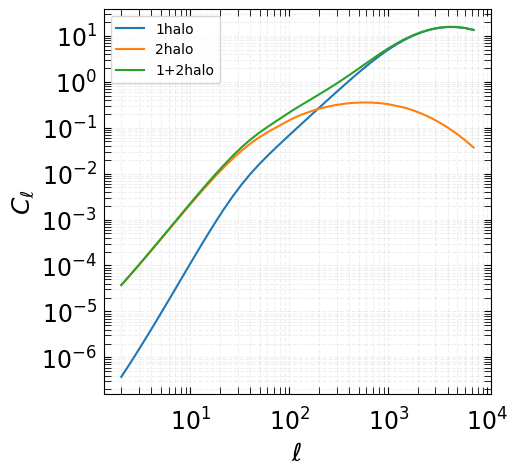

In [56]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"$\ell$ ",size=title_size)
ax.set_ylabel(r"$C_\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-1,1e4)
# ax.set_xlim(5e-2,1e1)
ax.plot(l,cl_yy_1h,label='1halo')
ax.plot(l,cl_yy_2h,label='2halo')
ax.plot(l,cl_yy_2h+cl_yy_1h,label='1+2halo')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()

## secondary computation without varying cosmo

In [57]:
%%time
c500_arr = np.linspace(1.1,1.7,10)
P0GNFW_arr = np.linspace(5.,10.,10)
cl_yy_1h_all = []
cl_yy_2h_all = []
for cp in c500_arr:
# for P0GNFWp in P0GNFW_arr:
    # print(cp)
    class_sz_params_to_update={
        'c500' : cp,
        # "P0GNFW": P0GNFWp,
    }
    M.compute_class_sz(class_sz_params_to_update)
    l = np.asarray(M.cl_sz()['ell'])
    cl_yy_1h_all.append(np.asarray(M.cl_sz()['1h']))
    cl_yy_2h_all.append(np.asarray(M.cl_sz()['2h']))

CPU times: user 1.44 s, sys: 11.3 ms, total: 1.45 s
Wall time: 426 ms


In [58]:
# cl_yy_1h_all

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


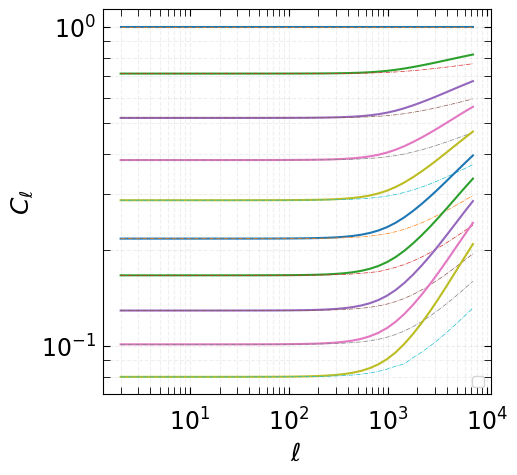

In [59]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"$\ell$ ",size=title_size)
ax.set_ylabel(r"$C_\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')

for ip,cp in enumerate(c500_arr):
    l = np.asarray(M.cl_sz()['ell'])
    cl_yy_1h = cl_yy_1h_all[ip]/cl_yy_1h_all[0]
    cl_yy_2h = cl_yy_2h_all[ip]/cl_yy_2h_all[0]
    ax.plot(l,cl_yy_1h)
    ax.plot(l,cl_yy_2h,lw=0.5,ls='-.')
    # ax.plot(l,cl_yy_2h+cl_yy_1h)
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()